<a href="https://colab.research.google.com/github/angusjf/angusjf.github.io/blob/master/KUL_CV_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

In [0]:
#@title ## Configuration { run: "auto" }

VOC_ROOT_FOLDER = "/content/VOCdevkit/VOC2009/" #@param {type: "string"}

Imports

In [0]:
import glob
import cv2
import os
import xml.dom.minidom as xmlparser
import numpy as np
from lxml import etree
from enum import IntEnum
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import torch
from skimage import io
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from albumentations import (
    Compose
)
import albumentations.augmentations.transforms as transforms

In [3]:
from keras import backend
# Tensorflow uses NxHxWxC by default
print(backend.image_data_format())

channels_last


Using TensorFlow backend.


Fetch data

In [4]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

--2020-04-27 17:02:46--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  4.97MB/s    in 3m 4s   

2020-04-27 17:05:50 (4.86 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 262MiB/s)


Utils for segmentation

In [0]:
# Based on https://github.com/tensorflow/models/blob/master/research/deeplab/utils/get_dataset_colormap.py
def bit_get(val, idx):
  return (val >> idx) & 1

# accepts HWC format
def label_to_color_image(label):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label. Got {}'.format(label.shape))

  if np.max(label) >= 512:
    raise ValueError(
        'label value too large: {} >= {}.'.format(
            np.max(label), 512))

  colormap = create_pascal_label_colormap()
  return colormap[label]

def create_pascal_label_colormap():

  colormap = np.zeros((512, 3), dtype=int)
  ind = np.arange(512, dtype=int)

  for shift in reversed(list(range(8))):
    for channel in range(3):
      colormap[:, channel] |= bit_get(ind, channel) << shift
    ind >>= 3

  return colormap


Preparing dataset

In [0]:
class VOCDataset(Sequence):
    CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
            'tvmonitor']

    def __init__(self, dataset_type, split, *args, **kwargs):
        super().__init__()

        self._whole_dataset = dataset_type(*args, **kwargs)
        self._subsets = dict()
        
        slices = np.round(np.cumsum([0] + split) * len(self._whole_dataset._ids)).astype(int)
        for i, name in enumerate(("train", "val", "tst")):
            self._subsets[name] = dataset_type(*args, **kwargs, subset_slice=slice(slices[i], slices[i + 1]))

    def tr_set(self):
        return self._subsets.get("train")

    def val_set(self):
        return self._subsets.get("val")

    def tst_set(self):
        return self._subsets.get("tst")

    def __len__(self):
        return len(self._whole_dataset)

    def __getitem__(self, idx):
        return self._whole_dataset[idx]

    def test_set(self):
        return self

LabelClass = IntEnum("LabelClass", {label: i + 1 for i, label in enumerate(VOCDataset.CLASSES)})

DAtaset for classification (one-hot encoding)

In [0]:
class VOCClassificationSubset(Sequence):
    def __init__(self, dataset_root_dir, batch_size=1, subset_slice=slice(0, None), transform=None):
        super().__init__()

        self._batch_size = batch_size
        self._dir = dataset_root_dir
        self._transform = transform
        with open(os.path.join(self._dir, "ImageSets/Main/trainval.txt")) as f:
            self._ids = tuple(filter(None, (map(lambda x: x.split(" ")[0], f.read().split("\n")))))
        # take subset
        self._ids = self._ids[subset_slice]
        self._labels = list()

        for single_id in self._ids:
            tree = etree.parse(os.path.join(self._dir, "Annotations", "{}.xml".format(single_id)))
            self._labels.append(list(map(
                lambda x: LabelClass[x],
                set(tree.xpath("//object/name/text()")) & set(VOCDataset.CLASSES)
            )))

    def __len__(self):
        return int(len(self._ids) / self._batch_size)

    def __getitem__(self, idx):
        data = [self._get_single_item(x) for x in range(idx * self._batch_size, (idx + 1) * self._batch_size)]
        images, labels = zip(*data)
        return np.array(images), np.array(labels)

    def _get_single_item(self, idx):
        item_id = self._ids[idx]

        labels = [label.value - 1 for label in self._labels[idx]]
        # one-hot encode
        encoded_labels = np.zeros((len(VOCDataset.CLASSES), ), dtype=int)
        encoded_labels[labels] = 1

        image = io.imread(os.path.join(self._dir, "JPEGImages", "{}.jpg".format(item_id)))
        if self._transform:
            image = self._transform(image=image).get("image")

        return image, encoded_labels    

264 88 88
440
(16, 500, 500, 3) (16, 20)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
LabelClass.sheep


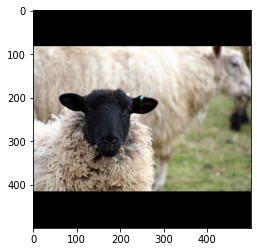

In [8]:
# Example for classification dataset
augmentation = Compose([
    transforms.PadIfNeeded(
        min_height=500, 
        min_width=500, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=0
    )
])

dataset = VOCDataset(
    VOCClassificationSubset, 
    split=[0.6, 0.2, 0.2], 
    dataset_root_dir=VOC_ROOT_FOLDER, 
    batch_size=16, 
    transform=augmentation
)
tr = dataset.tr_set()
val = dataset.val_set()
test = dataset.tst_set()
print(len(tr), len(val), len(test))
print(len(dataset))
# use validation for example
dataset = val


# getting sample
images, labels = dataset[1]
print(images.shape, labels.shape)
image, label = images[0], labels[0]

# NHWC format
print(label)

for i in np.squeeze(np.nonzero(label), axis=0):
    print(LabelClass(i + 1))

plt.imshow(image)
plt.show()

Dataset for segmentation

In [0]:
class VOCSegmentationDataset(Sequence):
    def __init__(self, dataset_root_dir, batch_size=1, subset_slice=slice(0, None), transform=None, input_transform=None):
        super().__init__()

        self._batch_size = batch_size
        self._dir = dataset_root_dir
        self._transform = transform
        self._input_transform = input_transform
        with open(os.path.join(self._dir, "ImageSets/Segmentation/trainval.txt")) as f:
            self._ids = tuple(filter(None, f.read().split("\n")))
        # take subset
        self._ids = self._ids[subset_slice]

    def __len__(self):
        return int(len(self._ids) / self._batch_size)

    def __getitem__(self, idx):
        data = [self._get_single_item(x) for x in range(idx * self._batch_size, (idx + 1) * self._batch_size)]
        images, masks, ROIs = zip(*data)
        return np.array(images), np.array(masks), np.array(ROIs)

    def _get_single_item(self, idx):
        item_id = self._ids[idx]

        # NHWC format
        image = io.imread(os.path.join(self._dir, "JPEGImages", "{}.jpg".format(item_id)))
        mask = io.imread(os.path.join(self._dir, "SegmentationClass", "{}.png".format(item_id)))[..., :3]
        voc_colormap = create_pascal_label_colormap()

        # convert mask to a single channel
        r_mask, g_mask, b_mask = np.transpose(mask, axes=(2, 0, 1))
        class_mask = np.zeros(mask.shape[:2] + (len(VOCDataset.CLASSES) + 1, ), dtype=np.uint8)

        for i in range(0, len(VOCDataset.CLASSES) + 1):
            color = voc_colormap[i]
            class_mask[..., i] = ((r_mask == color[0]) * (g_mask == color[1]) * (b_mask == color[2]))

        if self._transform:
            transformed = self._transform(image=image, class_mask=class_mask)
            
            image= transformed.get("image")
            class_mask = transformed.get("class_mask")
        
        if self._input_transform:
            image = self._input_transform(image=image).get("image")
        
        color = voc_colormap[255]
        ROI_mask = ((r_mask == color[0]) * (g_mask == color[1]) * (b_mask == color[2]))

        return image, class_mask, ROI_mask

899 300 300
1499
(1, 150, 150, 3)


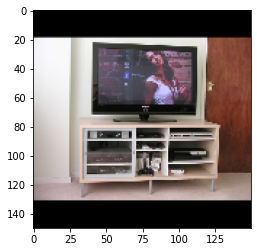

(150, 150, 21)


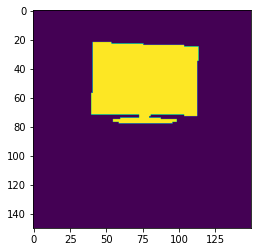

(150, 150)


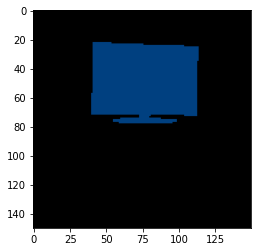

In [10]:
# Example for segmentation dataset
augmentation = Compose([
        transforms.ToFloat(),
        transforms.PadIfNeeded(
            min_height=500, 
            min_width=500, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0
        ),

        transforms.Resize(
            width=150,
            height=150
        ),
    ],
    additional_targets={
        'class_mask': 'image',
    }
)

dataset = VOCDataset(
    VOCSegmentationDataset, 
    split=[0.6, 0.2, 0.2], 
    dataset_root_dir=VOC_ROOT_FOLDER, 
    batch_size=1, 
    transform=augmentation
)
tr = dataset.tr_set()
val = dataset.val_set()
test = dataset.tst_set()
print(len(tr), len(val), len(test))
print(len(dataset))
# use validation for example
dataset = val

# getting sample (mask and image are stored in dict)
imgs, masks, ROImasks = dataset[1]
print(imgs.shape)
img = imgs[0]
mask = masks[0]
ROImask = ROImasks[0]

plt.imshow(img)
plt.show()

print(mask.shape)
mask = np.argmax(mask, axis=2)
plt.imshow(mask)
plt.show()

# reconstruction from single channel mask (value is pixel is equal to its class)
print(mask.shape)
plt.imshow(label_to_color_image(mask))
plt.show()

# Classificaion

In [0]:
# preprocessing
augmentation = Compose([
    transforms.PadIfNeeded(
        min_height=500, 
        min_width=500, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=0
    ),
    transforms.Resize(
        width=150,
        height=150
    ),
    transforms.ToFloat(),
    transforms.HorizontalFlip(),
    transforms.ShiftScaleRotate(),
    transforms.RandomBrightness()
])

# create dataset
dataset = VOCDataset(
    VOCClassificationSubset, 
    split=[0.9, 0.05, 0.05],
    dataset_root_dir=VOC_ROOT_FOLDER, 
    batch_size=32, 
    transform=augmentation
)

Used some tips for multi-label multi-class nns I found here:
[https://depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks]()

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation='sigmoid')
])

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),#lr=1e-6
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
training = dataset.tr_set()
validation = dataset.val_set()

history = model.fit(
    training,
    steps_per_epoch=len(training),
    validation_data=dataset.val_set(),
    validation_steps=len(validation),
    epochs=14
)

198/198 [==============================] - 38s 194ms/step - loss: 0.3144 - accuracy: 0.1765 - val_loss: 0.2629 - val_accuracy: 0.0994


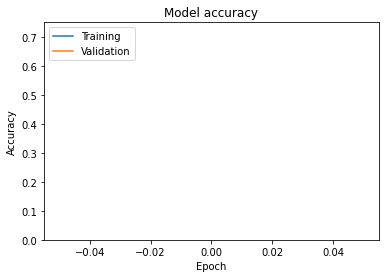

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.ylim(ymin=0, ymax=0.75)
plt.show()

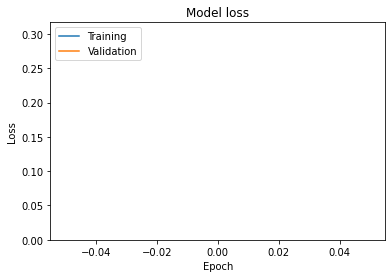

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.ylim(ymin=0)
plt.show()

In [0]:
predictions = model.predict(dataset.val_set())

most likley class:
 -> person
predictions:
[0.03260325 0.03811679 0.05785438 0.0314569  0.04802962 0.02213931
 0.08587855 0.06620959 0.08490324 0.0216028  0.0316737  0.08615964
 0.04005685 0.0359813  0.43701857 0.03981647 0.01869242 0.04710831
 0.02774719 0.04584928]
ground truth:
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0]


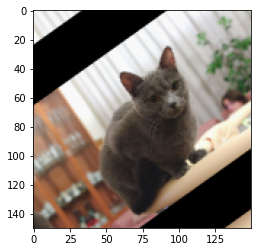

In [37]:
index = 29

img = dataset.val_set()[1][0][index]

plt.imshow(img)

print("most likley class:")
print(" -> " + ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
            'tvmonitor'][np.argmax(predictions[index])])

print("predictions:")
print(predictions[index])

print("ground truth:")
actual = dataset.val_set()[1][1][index]
print(actual)

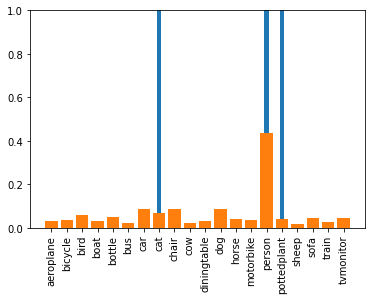

In [39]:
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
            'tvmonitor']
y_pos = np.arange(len(labels))
_ = plt.bar(y_pos, actual, width=0.3)
_ = plt.bar(y_pos, predictions[index])
_ = plt.xticks(y_pos, labels, rotation=90)
_ = plt.ylim(ymin=0, ymax=1)